# Bird Species Classification:
### Using Computer Vision to Classify 525 Different Bird Species

##### By: David Hartsman and Heath Jones

In this notebook, we will perform some preliminary EDA of the dataset, and we will also create our first CNN model. The data contain multiple images of 525 different species of birds. Our task will be to develop a model capable of accurate classification of these species. The tools we plan on using are Python, Tensorflow, Keras, as well as matplotlib for visualizing the images and plotting performance metrics. 

<hr style="border: 2px solid blue">

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow.keras

import datetime
import os

from tqdm import tqdm

from pathlib import Path

# To streamline the naming and generate tabular image data
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Keras model types and layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras import backend

# Metrics for classification
from sklearn.metrics import classification_report
from tensorflow.keras.metrics import FalseNegatives, FalsePositives, TrueNegatives, TruePositives

import warnings
warnings.filterwarnings("ignore")

2024-02-18 15:16:53.453951: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


<hr style="border: 2px solid blue">

### Data Inspection from birds.csv: directories and supposed labels for each species

In [3]:
# Load in the csv file

df = pd.read_csv('/Users/samalainabayeva/Desktop/FLAT_IRON!!!/birds_archive/birds.csv')

In [4]:
# Visual inspection - directory info and labels

df.head()

,class id,filepaths,labels,data set,scientific name
0,0.0,train/ABBOTTS BABBLER/001.jpg,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI
1,0.0,train/ABBOTTS BABBLER/007.jpg,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI
2,0.0,train/ABBOTTS BABBLER/008.jpg,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI
3,0.0,train/ABBOTTS BABBLER/009.jpg,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI
4,0.0,train/ABBOTTS BABBLER/002.jpg,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI


In [58]:
# Making a dictionary of scientific names

grouped = df.groupby("labels")

# Create a dictionary to store the most common scientific name for each group
scientific_names = {}

for group_name, group_data in grouped:
    # Find the mode of the 'scientific name' column within the group
    mode_scientific_name = group_data['scientific name'].mode()
    
    # If there is a mode...
    if not mode_scientific_name.empty:
        # Store the mode value in the dictionary
        scientific_names[group_name] = mode_scientific_name.iloc[0]

# 525 unique keys, 525 unique values
print(len(scientific_names.keys()), len(scientific_names.values()))        
scientific_names['AFRICAN CROWNED CRANE']

525 525


'BALEARICA REGULORUM'

In [55]:
# Manual inspection of the dictionary

df.query('labels == "AFRICAN CROWNED CRANE"').head()

,class id,filepaths,labels,data set,scientific name
522,3.0,train/AFRICAN CROWNED CRANE/012.jpg,AFRICAN CROWNED CRANE,train,BALEARICA REGULORUM
523,3.0,train/AFRICAN CROWNED CRANE/010.jpg,AFRICAN CROWNED CRANE,train,BALEARICA REGULORUM
524,3.0,train/AFRICAN CROWNED CRANE/007.jpg,AFRICAN CROWNED CRANE,train,BALEARICA REGULORUM
525,3.0,train/AFRICAN CROWNED CRANE/009.jpg,AFRICAN CROWNED CRANE,train,BALEARICA REGULORUM
526,3.0,train/AFRICAN CROWNED CRANE/008.jpg,AFRICAN CROWNED CRANE,train,BALEARICA REGULORUM


In [6]:
# Almost 90k images
df.shape

(89885, 5)

In [7]:
# There is a 2 - to - 1 ratio of max class observations to min class observations
df["class id"].value_counts()

class id
426.0    273
286.0    258
181.0    243
367.0    243
40.0     230
        ... 
357.0    140
445.0    140
375.0    140
211.0    140
408.0    140
Name: count, Length: 525, dtype: int64

<hr style="border: 2px solid blue">

In [5]:
# Using os library to access the files in the "train" path

path = "/Users/samalainabayeva/Desktop/FLAT_IRON!!!/birds_archive"

print(os.listdir(os.path.join(path, "train"))[:5])

['CREAM COLORED WOODPECKER', 'CAMPO FLICKER', 'RUFUOS MOTMOT', 'WHITE TAILED TROPIC', 'KOOKABURRA']


<hr style="border: 2px solid blue">

### Using Tensorflow's ImageDataGenerator

In [26]:
from keras.preprocessing.image import ImageDataGenerator

# Define the main directory containing subdirectories for each bird species
main_directory = '/Users/samalainabayeva/Desktop/FLAT_IRON!!!/birds_archive/train'

# Define data augmentation and normalization options
image_generator = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values to [0,1]
    rotation_range=20,  # Randomly rotate images by up to 20 degrees
    width_shift_range=0.2,  # Randomly shift images horizontally
    height_shift_range=0.2,  # Randomly shift images vertically
    shear_range=0.2,  # Shear intensity
    zoom_range=0.2,  # Randomly zoom images
    horizontal_flip=True,  # Randomly flip images horizontally
    fill_mode='nearest'  # Fill in missing pixels with the nearest value
)

# Generate batches of augmented data from images in the directory
data_generator = image_generator.flow_from_directory(
    main_directory,
    seed=13,
    target_size=(224, 224),  # Resize images to 224x224 pixels
    batch_size=32,  # Define batch size
    class_mode='categorical'  # Use categorical labels
)

Found 84635 images belonging to 525 classes.


In [27]:
# Check the class indices (corresponding to bird species labels)

# Returns a dictionary of string:numeric_code for the class labels
class_indices = data_generator.class_indices

# Print type, first 5 keys
print(type(class_indices))
print("Class indices:", list(class_indices.keys())[:5])

<class 'dict'>
Class indices: ['ABBOTTS BABBLER', 'ABBOTTS BOOBY', 'ABYSSINIAN GROUND HORNBILL', 'AFRICAN CROWNED CRANE', 'AFRICAN EMERALD CUCKOO']


In [28]:
# Generators for Validation/Test Data

# Validation generator
valid_generator = image_generator.flow_from_directory(
    os.path.join(path, "valid"),
    seed=13,
    target_size=(224, 224),  # Resize images to 224x224 pixels
    batch_size=32,  # Define batch size
    class_mode='categorical'  # Use categorical labels
)

# Test generator
test_generator = image_generator.flow_from_directory(
    os.path.join(path, "test"),
    seed=13,
    target_size=(224, 224),  # Resize images to 224x224 pixels
    batch_size=32,  # Define batch size
    class_mode='categorical')  # Use categorical labels

Found 2625 images belonging to 525 classes.
Found 2625 images belonging to 525 classes.


<hr style="border: 4px solid blue">

### Model Creation

In [12]:
# Instantiation
model = Sequential()

# First convolutional layer, then max pooling 
model.add(Conv2D(filters=16, kernel_size=(3,3), strides=1, activation="relu", input_shape=(224,224,3)))
model.add(MaxPooling2D()) # condenses information over a set region - (2,2) default - returns the max of the region

model.add(Conv2D(32, (3,3), 1, activation="relu"))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation="relu"))
model.add(MaxPooling2D())

# creates a 1 Dimensional tensor shape of (x, 1)
model.add(Flatten())

model.add(Dense(224, activation="relu"))
model.add(Dense(525, activation="softmax"))

2024-02-05 20:45:41.434179: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [13]:
# Model Compilation

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics="accuracy")

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 16)       0

In [15]:
# Specifying a path for tensorboard logs

logdir = "logs"

In [16]:
# Using os library to access the files in the "train" path

path = "/Users/samalainabayeva/Desktop/FLAT_IRON!!!/birds_archive"

In [17]:
# Callback for tracking model training

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=os.path.join(path, logdir))

In [18]:
# Fitting the model -> 1 Epoch takes about 20 minutes

hist = model.fit(data_generator, epochs=20, validation_data=valid_generator, callbacks=[tensorboard_callback],\
                 workers=6)

Epoch 1/20
2645/2645 [==============================] - 1267s 479ms/step - loss: 5.6774 - accuracy: 0.0202 - val_loss: 5.1951 - val_accuracy: 0.0446
Epoch 2/20
2645/2645 [==============================] - 1284s 485ms/step - loss: 4.9145 - accuracy: 0.0758 - val_loss: 4.4070 - val_accuracy: 0.1196
Epoch 3/20
2645/2645 [==============================] - 1286s 486ms/step - loss: 4.3153 - accuracy: 0.1454 - val_loss: 4.0625 - val_accuracy: 0.1806
Epoch 4/20
2645/2645 [==============================] - 1291s 488ms/step - loss: 3.9013 - accuracy: 0.2023 - val_loss: 3.5776 - val_accuracy: 0.2373
Epoch 5/20
2645/2645 [==============================] - 1286s 486ms/step - loss: 3.6206 - accuracy: 0.2442 - val_loss: 3.3825 - val_accuracy: 0.2750
Epoch 6/20
2645/2645 [==============================] - 1303s 492ms/step - loss: 3.3935 - accuracy: 0.2837 - val_loss: 3.1130 - val_accuracy: 0.3314
Epoch 7/20
2645/2645 [==============================] - 1285s 486ms/step - loss: 3.2274 - accuracy: 0.3108

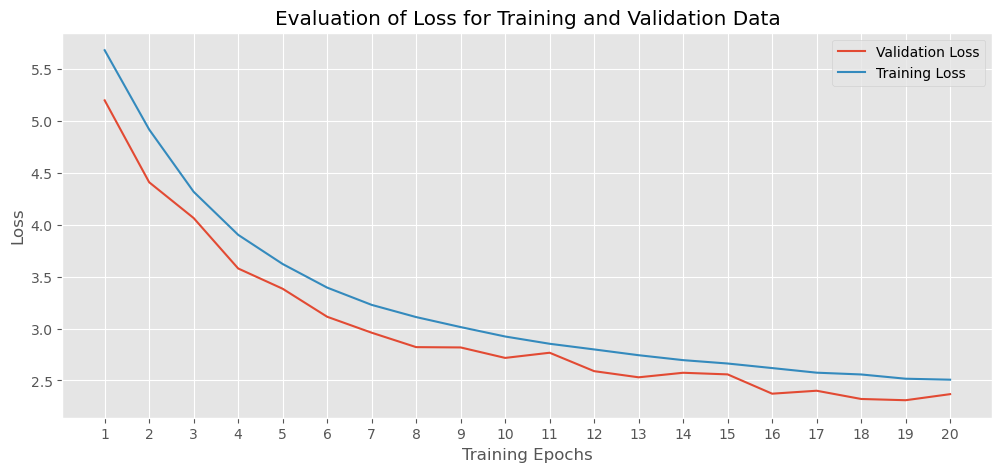

In [262]:
# Plotting loss
def plot_model_logs(history_object, epochs:int, metric:str, figsize=(12,5)):
    """
    Plotting function to compare training metrics and validation metrics during for a Keras model. 
    """
    # Style choice
    plt.style.use("ggplot")
    
    # Create the figure
    fig, ax = plt.subplots(figsize=figsize)                       
    
    # Validation data lineplot
    ax.plot(np.arange(0, epochs, 1), history_object.history[f"val_{metric}"], label=f"Validation {metric.title()}")
    
    # Train data lineplot
    ax.plot(np.arange(0, epochs, 1), history_object.history[metric], label = f"Training {metric.title()}")
    
    # Ticks, labels, legend
    ax.set_xticks(range(20))
    ax.set_xticklabels(range(1, (epochs+1)))
    ax.legend()
    ax.set_title(f"Evaluation of {metric.title()} for Training and Validation Data")
    ax.set_xlabel("Training Epochs")
    ax.set_ylabel(f"{metric.title()}");
    
# Function call for loss metrics
plot_model_logs(hist, 20, "loss")

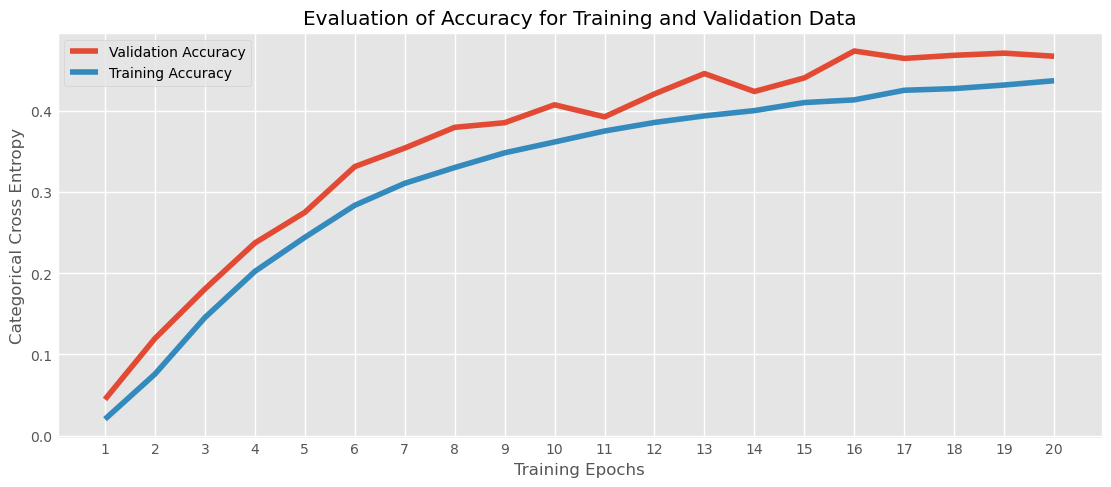

In [55]:
# Plotting the accuracy over training 

plot_model_logs(hist, 20, "accuracy")

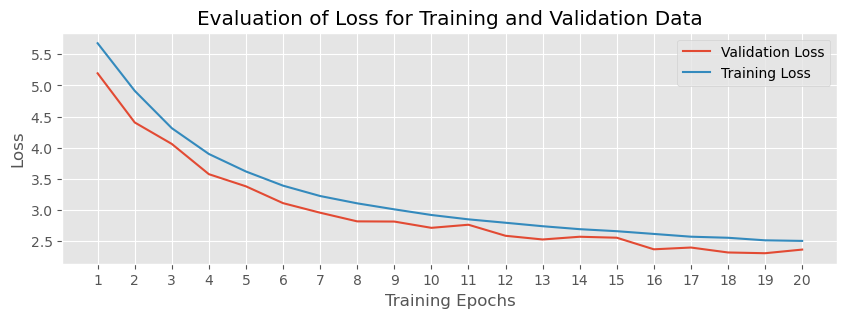

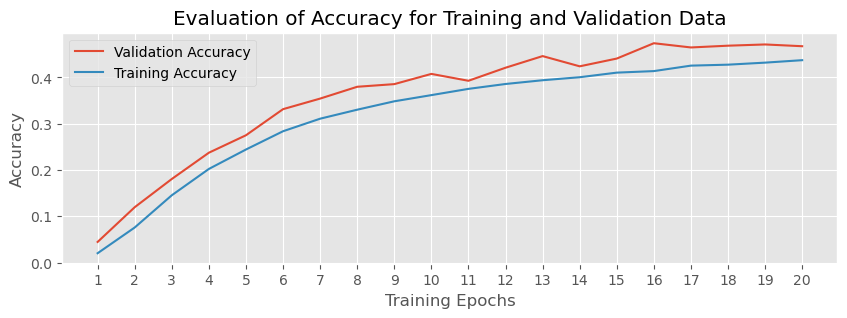

In [263]:
# Easiest means of side-by-side plotting given initial function definition

metrics = ["loss", "accuracy"]
for i in metrics:
    plot_model_logs(hist, 20, i, figsize=(10,3))

In [72]:
# Extract the history attribute and transform it into a dataframe

model_logs = pd.DataFrame(hist.history)

In [73]:
# Create an Epochs column, could've been done more easily in retrospect

model_logs.index = range(1, 21)

In [75]:
# DF formatting

model_logs.rename_axis('Epochs', inplace=True)
model_logs

,loss,accuracy,val_loss,val_accuracy
Epochs,,,,
1,5.677375,0.020193,5.195110,0.044571
2,4.914515,0.075772,4.407012,0.119619
3,4.315264,0.145401,4.062500,0.180571
4,3.901346,0.202280,3.577578,0.237333
5,3.620565,0.244249,3.382480,0.275048
6,3.393504,0.283736,3.113045,0.331429
7,3.227394,0.310841,2.959660,0.354286
8,3.109955,0.330277,2.820844,0.379810
9,3.013737,0.348414,2.817858,0.385524


In [269]:
# Additional formatting

# model_logs.drop(columns="index", inplace=True)
model_logs.head()

,Epochs,loss,accuracy,val_loss,val_accuracy
0,1,5.677375,0.020193,5.195110,0.044571
1,2,4.914515,0.075772,4.407012,0.119619
2,3,4.315264,0.145401,4.062500,0.180571
3,4,3.901346,0.202280,3.577578,0.237333
4,5,3.620565,0.244249,3.382480,0.275048


In [270]:
### Saving the information from the first model

# model_logs.to_csv("/Users/samalainabayeva/Desktop/FLAT_IRON!!!/birds_archive/model_1_logs.csv")

<hr style="border: 2px solid blue">

### Saving the model

In [182]:
from tensorflow.keras.models import load_model

# model.save() requires a filepath to save the model 
model.save(os.path.join(path, "models", "bird_classifier_1.h5"))

In [184]:
test_load = load_model(os.path.join(path, "models", "bird_classifier_1.h5"))

In [190]:
np.argmax(test_load.predict(batch[0])[3])

1/1 [==============================] - 0s 151ms/step


100

<hr style="border: 2px solid blue">

### Generating Predictions on Test Data:
Here, we took a look at how the model predicted the test data in our dataset. The four images we generated predictions for are found below, as is a comparison of images between true/predicted bird species in the case of two incorrect predictions. The early returns are promising, but there is still much room for improvement. 

In [153]:
# Images from Test Data
batch = test_generator.next()

In [154]:
# Confirmation of scaling success

batch[0].min(), batch[0].max()

(0.0, 1.0)

### Recreation of dictionary to translate prediction np.argmax() to a string label

In [155]:
# Labels from the generator 
class_indices = test_generator.class_indices

In [156]:
# Numbers as keys, strings as values

reverse_dict = {val:key for key, val in class_indices.items()}

In [157]:
# These are the labels of the first batch of 32 images

num_classes = batch[1].shape[1]
numeric_labels = np.argmax(batch[1], axis=1)
numeric_labels

array([366, 520, 408, 446, 229, 393, 216,  23, 350, 385, 446, 132, 428,
       124, 500, 293,  10, 177, 408, 110, 230,  57,  95, 345, 200,  16,
       290, 318, 139, 425,  40, 447])

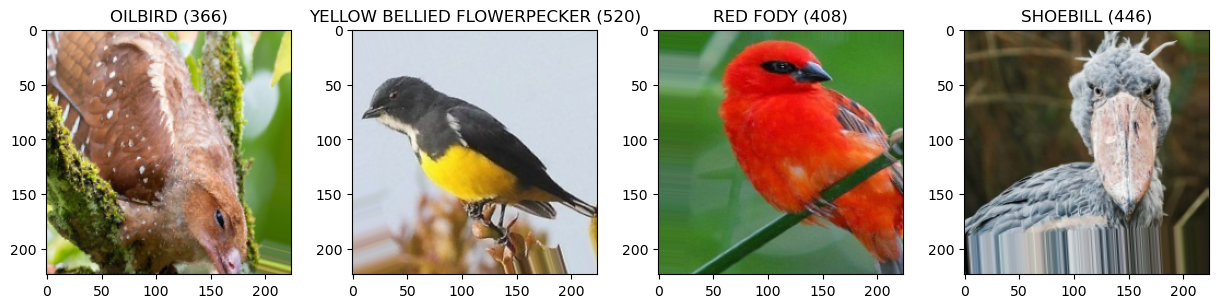

In [159]:
# Plotting images with the various augmentations applied in preprocessing
plt.style.use("default")
fig, ax = plt.subplots(ncols=4, figsize=(15,5), gridspec_kw={"wspace":.25})
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    
    # Because the labels extracted from the "image_generator.flow_from_directory()" method are numpy arrays
    # with as many columns as classes, I have to use the np.argmax() function to find the correct labels 0-524
    title = reverse_dict[np.argmax(batch[1][idx])]
    ax[idx].set_title(f"{title} ({np.argmax(batch[1][idx])})")

<hr style="border: 3px solid blue">

### Model Predictions: 

In [162]:
# Verifying the dict value
reverse_dict[366]

'OILBIRD'

In [160]:
# First image - correct
np.argmax(model.predict(batch[0])[0])

1/1 [==============================] - 0s 152ms/step


366

In [169]:
# First Image - Correct Prediction, pred_proba at .521, reasonably confident
model.predict(batch[0])[0][366], model.predict(batch[0])[0][365], model.predict(batch[0])[0][367]

1/1 [==============================] - 0s 134ms/step


(0.5211118, 5.4819513e-05, 4.2611842e-05)

<hr style="border: 2px solid blue">

In [161]:
# Second image, incorrect
np.argmax(model.predict(batch[0])[1])

1/1 [==============================] - 0s 130ms/step


188

In [177]:
# Second Image - Incorrect Prediction, pred_proba only at .293, low-confidence
model.predict(batch[0])[1][188], model.predict(batch[0])[1][187], model.predict(batch[0])[1][189]

1/1 [==============================] - 0s 128ms/step


(0.29255098, 3.289555e-11, 2.8422529e-09)

<hr style="border: 2px solid blue">

In [172]:
# Third image, correct
np.argmax(model.predict(batch[0])[2])

1/1 [==============================] - 0s 135ms/step


408

In [178]:
# Third Image - Incorrect Prediction, pred_proba only at .62, high-confidence
model.predict(batch[0])[2][408], model.predict(batch[0])[2][407], model.predict(batch[0])[2][409]

1/1 [==============================] - 0s 139ms/step


(0.6207071, 1.0943113e-06, 5.210214e-13)

<hr style="border: 2px solid blue">

In [173]:
# Fourth image, incorrect
np.argmax(model.predict(batch[0])[3])

1/1 [==============================] - 0s 134ms/step


100

In [179]:
# Fourth Image - Incorrect Prediction, pred_proba only at .149, low-confidence
model.predict(batch[0])[3][100], model.predict(batch[0])[3][99], model.predict(batch[0])[3][101]

1/1 [==============================] - 0s 130ms/step


(0.14866696, 0.0017291887, 8.317293e-05)

<hr style="border: 2px solid blue">

In [174]:
# Incorrectly predicted species:
reverse_dict[188], reverse_dict[100]

('DAURIAN REDSTART', 'BLUE HERON')

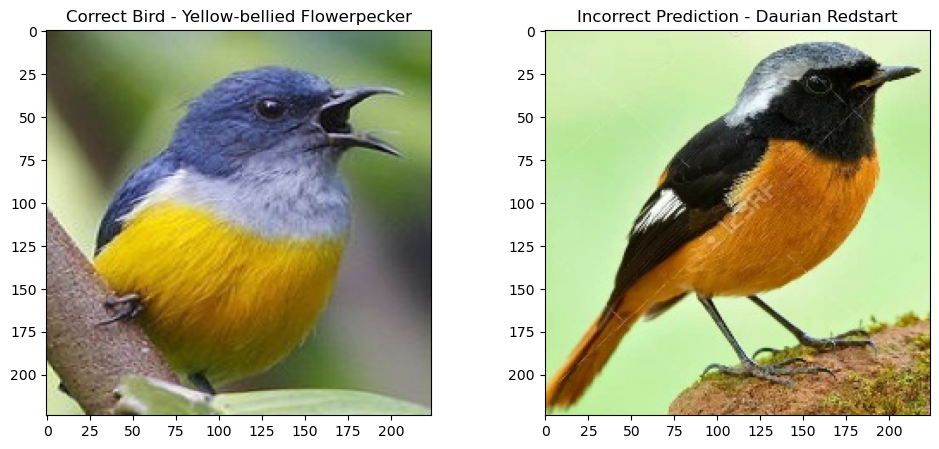

In [168]:
# Incorrect prediction - easy to see some of the signals that the model keyed in to

import matplotlib.image as mpimg

# Loading image data
image_path = '/Users/samalainabayeva/Desktop/FLAT_IRON!!!/birds_archive/test/YELLOW BELLIED FLOWERPECKER/1.jpg'
img = mpimg.imread(image_path)
image2_path = '/Users/samalainabayeva/Desktop/FLAT_IRON!!!/birds_archive/test/DAURIAN REDSTART/1.jpg'
img2 = mpimg.imread(image2_path)

# Plotting each image in two rows for side-by-side comparison
fig, ax = plt.subplots(ncols=2, figsize=(15,5), gridspec_kw={"wspace":-0.25})
ax[0].imshow(img)
ax[0].set_title("Correct Bird - Yellow-bellied Flowerpecker")
ax[1].imshow(img2)
ax[1].set_title("Incorrect Prediction - Daurian Redstart");

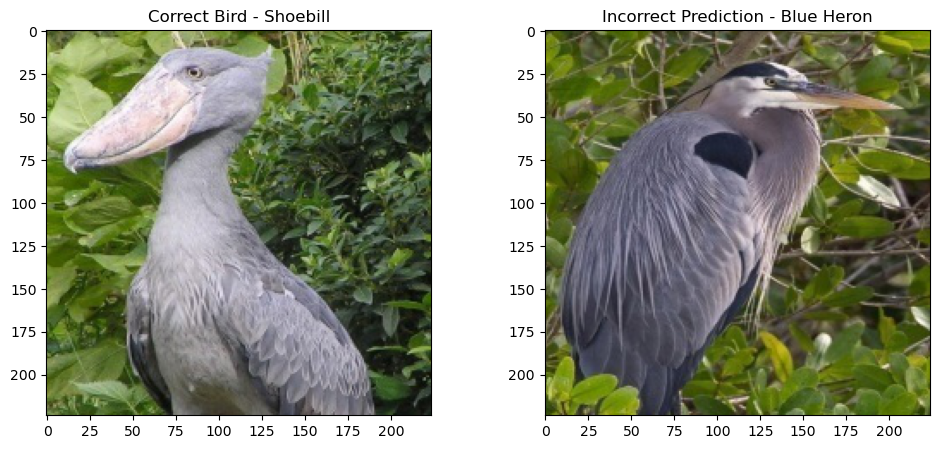

In [180]:
# Incorrect prediction 4th image above - same procedure as previous plot

import matplotlib.image as mpimg

image_path = '/Users/samalainabayeva/Desktop/FLAT_IRON!!!/birds_archive/test/SHOEBILL/1.jpg'
img = mpimg.imread(image_path)
image2_path = '/Users/samalainabayeva/Desktop/FLAT_IRON!!!/birds_archive/test/BLUE HERON/1.jpg'
img2 = mpimg.imread(image2_path)

fig, ax = plt.subplots(ncols=2, figsize=(15,5), gridspec_kw={"wspace":-0.25})
ax[0].imshow(img)
ax[0].set_title("Correct Bird - Shoebill")
ax[1].imshow(img2)
ax[1].set_title("Incorrect Prediction - Blue Heron");

<hr style="border: 2px solid blue">

### Predictions on truly unseen data
The final preliminary step we took in this notebook was to see how our model would perform on unseen data. We downloaded the following image from the internet. Its dimensions needed reshaping, further complicating our model's ability to predict accurately. 

In [192]:
# File found on the internet, not from the training data
os.listdir(os.path.join(path, "unseen_images"))

['abbots_babbler.jpg']

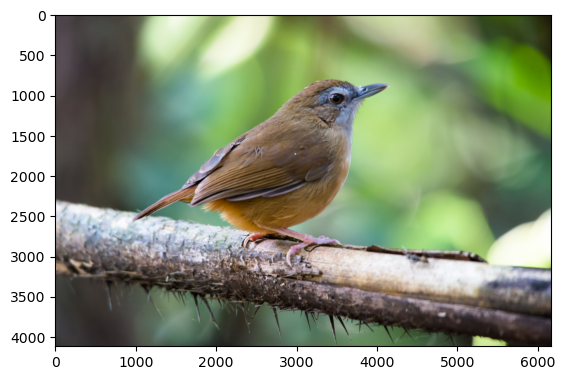

In [205]:
# Read in the image
img = mpimg.imread(os.path.join(path, "unseen_images", "abbots_babbler.jpg"))

# Image with dimensions and appearance exactly as downloaded
plt.imshow(img);

In [206]:
# The above image is 4116 pixels by 6167 pixels
print(img.shape)

(4116, 6167, 3)


(4116, 6167, 3)


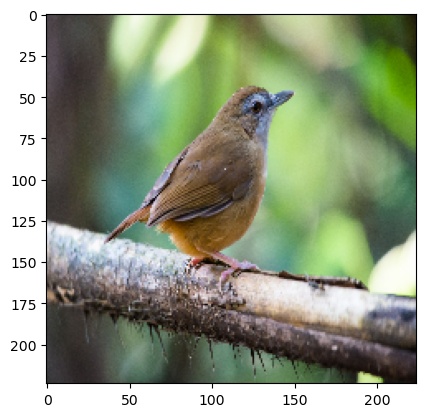

In [204]:
# Re-size the image
print(img.shape)

# tf.image.resize(<image>, <(*new_pixel_dims)>)
resized_image = tf.image.resize(img, (224,224))

# The .numpy() and .astype() methods are required, otherwise this image looks quite strange
# .numpy() Returns:A NumPy array of the same shape and dtype or a NumPy scalar, if this Tensor has rank 0.
# Not 100% clear on why .astype(int) is required, but message:
    # Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
# appears otherwise

plt.imshow(resized_image.numpy().astype(int));

In [207]:
# Getting the model to generate a prediction by using np.expand_dims() to deal with the issue of batch size
y_pred = model.predict(np.expand_dims(resized_image/255, 0))

1/1 [==============================] - 0s 32ms/step


In [213]:
# predicts class 218, roughly .284 pred_proba
np.argmax(y_pred[0]), y_pred[0][217:220]

(218, array([1.3816348e-06, 2.8405529e-01, 2.5437139e-05], dtype=float32))

In [215]:
# Incorrectly predicts a European Turtle Dove
reverse_dict[218]

'EUROPEAN TURTLE DOVE'

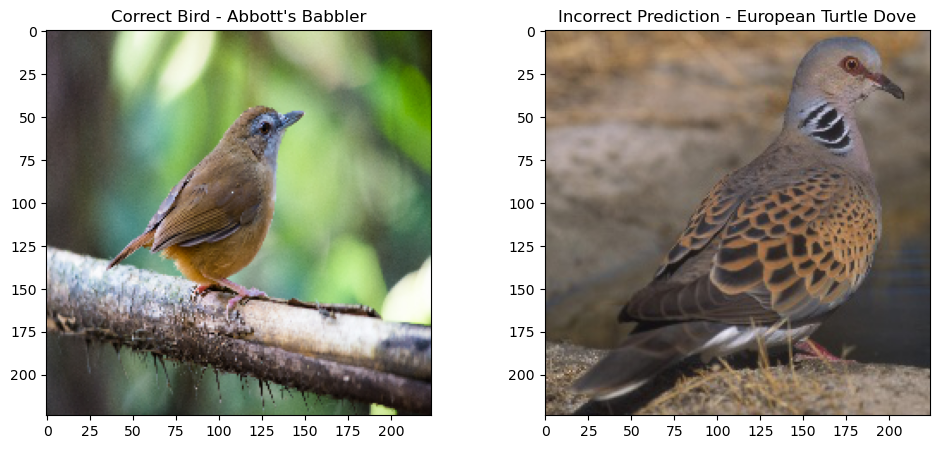

In [217]:
# Incorrect prediction unseen image above

import matplotlib.image as mpimg

image2_path = '/Users/samalainabayeva/Desktop/FLAT_IRON!!!/birds_archive/train/EUROPEAN TURTLE DOVE/002.jpg'
img2 = mpimg.imread(image2_path)

fig, ax = plt.subplots(ncols=2, figsize=(15,5), gridspec_kw={"wspace":-0.25})
ax[0].imshow(resized_image.numpy().astype(int))
ax[0].set_title("Correct Bird - Abbott's Babbler")
ax[1].imshow(img2)
ax[1].set_title("Incorrect Prediction - European Turtle Dove");

### This is maybe the worst incorrect prediction so far based on the visual appearances of the birds. The pred_proba value is only .284, so the prediction is low-confidence.

<hr style="border: 3px solid blue">

### Checking labels for verification purposes

In [219]:
# Check the class indices (corresponding to bird species labels)

# Returns a dictionary of string:numeric_code for the class labels
class_indices = data_generator.class_indices

# Print type, first 5 keys
print(type(class_indices))
print("Class indices:", list(class_indices.keys())[:5])

<class 'dict'>
Class indices: ['ABBOTTS BABBLER', 'ABBOTTS BOOBY', 'ABYSSINIAN GROUND HORNBILL', 'AFRICAN CROWNED CRANE', 'AFRICAN EMERALD CUCKOO']


In [234]:
# Verification process, these two label dictionaries are equivalent, whereas the validation label dict is NOT
test_generator.class_indices == class_indices, valid_generator.class_indices == class_indices

(True, False)

##### Different label sets
One of the issues is the presence of an additional " " in a label string. The discrepancies with the csv dataframe are far more numerous. This should not be an issue, but the following cells illustrate the dislocation between the label sets. 

In [23]:
# Labels from the birds.csv file
df_labels_dict = df.groupby("labels")["class id"].min().astype(int).to_dict()

In [29]:
# Checking values from validation data
valid_indices = valid_generator.class_indices

In [30]:
# Trying to verify that all class labels are the same after the last prediction

# Find keys present in class_indices but not in val_indices
keys_only_in_A = set(class_indices.keys()) - set(valid_indices.keys())

# Find keys present in val_indices but not in class_indices
keys_only_in_B = set(valid_indices.keys()) - set(class_indices.keys())

# Find common keys in both dictionaries
common_keys = set(class_indices.keys()) & set(valid_indices.keys())

# Find values that differ between common keys
differing_values = [(key, class_indices[key], valid_indices[key]) for key in common_keys if class_indices[key] != valid_indices[key]]

# Print results
print("Keys only in A:", keys_only_in_A)
print("Keys only in B:", keys_only_in_B)
print("Differing values for common keys:", differing_values)

Keys only in A: {'PARAKETT  AUKLET'}
Keys only in B: {'PARAKETT AUKLET'}
Differing values for common keys: []


In [31]:
# Verifying that the numeric values are the same even though the keys differ, AND THEY ARE THE SAME

valid_indices["PARAKETT AUKLET"], class_indices["PARAKETT  AUKLET"]  # Note the extra space

(380, 380)

<hr style="border: 2px solid blue">

### The labels between the keras generator and csv file are significantly different

In [33]:
# Trying to verify that all class labels in the DATAFRAME are the same after the last prediction

# Find keys present in class_indices but not in df_indices
keys_only_in_A = set(class_indices.keys()) - set(df_labels_dict.keys())

# Find keys present in df_indices but not in class_indices
keys_only_in_B = set(df_labels_dict.keys()) - set(class_indices.keys())

# Find common keys in both dictionaries
common_keys = set(class_indices.keys()) & set(df_labels_dict.keys())

# Find values that differ between common keys
differing_values = [(key, class_indices[key], df_labels_dict[key]) for key in common_keys if class_indices[key] != df_labels_dict[key]]

# Print results
print("Keys only in A:", keys_only_in_A)
print("Keys only in B:", keys_only_in_B)

# There are many many many different values
print("Differing values for common keys:", differing_values[:5])

Keys only in A: {'PARAKETT  AUKLET'}
Keys only in B: {'PARAKETT  AKULET'}
Differing values for common keys: [('HARLEQUIN QUAIL', 277, 272), ('CRESTED CARACARA', 169, 166), ('NORTHERN FULMAR', 357, 351), ('PALM NUT VULTURE', 378, 371), ('LILAC ROLLER', 327, 321)]


In [35]:
# From the generator...

class_indices["KNOB BILLED DUCK"]

321

In [34]:
# From the csv file...

df_labels_dict["KNOB BILLED DUCK"]

522

<hr style="border: 4px solid blue">

### The next steps...
... of the modeling process will take place in a [second notebook](https://github.com/dvdhartsman/Bird_Species_Image_Classification/blob/main/Bird_Classification_1.ipynb#:~:text=Bird_Classification_2). There, more model iterations will be created, hopefully leading to improved performance and better understanding of optimal CNN architecture for this specific problem. 